In [1]:
%load_ext autotime

time: 0 ns


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool
from boruta import BorutaPy
import category_encoders as ce
import warnings
import string
warnings.filterwarnings('ignore')

time: 11.5 s


In [3]:
import spacy
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import re
from nltk.corpus import movie_reviews, stopwords
from nltk.tokenize import word_tokenize
from normalise import normalise
import warnings
import string
warnings.filterwarnings('ignore')

time: 18.4 s


In [4]:
data_train = pd.read_csv('train.csv')

time: 2.5 s


In [5]:
#data_train.price = np.log(data_train.price)

time: 0 ns


In [6]:
data_test = pd.read_csv('test.csv')

time: 1.3 s


In [7]:
data_train.isna().sum(), data_test.isna().sum()

(id                                      0
 name                                    6
 summary                              1797
 space                               18465
 description                          1017
 experiences_offered                     0
 neighborhood_overview               21639
 notes                               32379
 transit                             22053
 access                              23429
 interaction                         24705
 house_rules                         23744
 host_id                                 0
 host_since                             11
 host_about                          23662
 host_response_time                  20686
 host_response_rate                  20689
 host_is_superhost                      11
 host_has_profile_pic                   11
 host_identity_verified                 11
 neighbourhood_cleansed                  0
 zipcode                              1473
 latitude                                0
 longitude 

time: 172 ms


In [8]:
reviews = pd.read_csv('reviews.csv')

time: 6.95 s


In [9]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51815 entries, 0 to 51814
Data columns (total 43 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                51815 non-null  int64  
 1   name                              51809 non-null  object 
 2   summary                           50018 non-null  object 
 3   space                             33350 non-null  object 
 4   description                       50798 non-null  object 
 5   experiences_offered               51815 non-null  object 
 6   neighborhood_overview             30176 non-null  object 
 7   notes                             19436 non-null  object 
 8   transit                           29762 non-null  object 
 9   access                            28386 non-null  object 
 10  interaction                       27110 non-null  object 
 11  house_rules                       28071 non-null  object 
 12  host

In [10]:
data_train.describe()

,id,host_id,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,price
count,5.181500e+04,5.181500e+04,51815.000000,51815.000000,51815.000000,51812.000000,51796.000000,51743.000000,15.000000,33897.000000,38364.000000,51815.000000,51815.000000,51815.000000,51815.000000
mean,2.238119e+07,8.122630e+07,51.509058,-0.127937,3.225089,1.294227,1.399027,1.773438,991.133333,192.249019,42.472891,1.561401,7.052359,3.959548,115.015787
std,4.648209e+06,6.712667e+07,0.045575,0.092781,2.002458,0.620269,0.907317,1.224066,933.178965,310.090851,44.525508,1.282639,13.353841,13.994390,201.599587
min,1.278600e+05,4.775000e+03,51.294794,-0.501305,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,1.874920e+07,2.049720e+07,51.486162,-0.187733,2.000000,1.000000,1.000000,1.000000,242.000000,0.000000,15.000000,1.000000,0.000000,1.000000,45.000000
50%,2.235012e+07,6.358767e+07,51.513346,-0.126478,2.000000,1.000000,1.000000,1.000000,753.000000,100.000000,30.000000,1.000000,0.000000,2.000000,80.000000
75%,2.655883e+07,1.362233e+08,51.535516,-0.070239,4.000000,1.500000,2.000000,2.000000,1600.000000,250.000000,60.000000,2.000000,10.000000,3.000000,135.000000
max,2.979850e+07,2.241824e+08,51.679199,0.285395,20.000000,14.000000,12.000000,16.000000,3000.000000,4098.000000,614.000000,30.000000,235.000000,1125.000000,13700.000000


time: 141 ms


In [11]:
data_test.describe()

,id,host_id,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights
count,2.300000e+04,2.300000e+04,23000.000000,23000.000000,23000.000000,22828.000000,22976.000000,22916.000000,460.000000,12971.000000,15346.000000,23000.000000,23000.000000,23000.000000
mean,7.085252e+06,2.213766e+07,51.510400,-0.128034,2.974870,1.262901,1.395630,1.704268,614.584783,238.832935,36.185977,1.487739,8.002870,4.409261
std,4.016220e+06,1.978853e+07,0.046855,0.088549,1.875019,0.550071,0.846107,1.242860,814.130861,306.990518,34.915599,1.154723,14.208824,14.207886
min,9.554000e+03,5.160000e+02,51.297329,-0.487862,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
25%,3.787914e+06,5.089983e+06,51.480921,-0.189259,2.000000,1.000000,1.000000,1.000000,120.000000,85.000000,15.000000,1.000000,0.000000,1.000000
50%,7.346500e+06,1.694597e+07,51.515394,-0.120675,2.000000,1.000000,1.000000,1.000000,491.500000,153.000000,30.000000,1.000000,0.000000,2.000000
75%,1.040060e+07,3.459069e+07,51.541960,-0.069771,4.000000,1.500000,2.000000,2.000000,823.500000,300.000000,50.000000,1.000000,15.000000,3.000000
max,1.356186e+07,2.099118e+08,51.675010,0.258924,16.000000,8.000000,10.000000,16.000000,10710.000000,4040.000000,595.000000,24.000000,231.000000,500.000000


time: 109 ms


In [12]:
data_train.select_dtypes(include=['float64', 'int64']).columns

Index(['id', 'host_id', 'latitude', 'longitude', 'accommodates', 'bathrooms',
       'bedrooms', 'beds', 'square_feet', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'price'],
      dtype='object')

time: 16 ms


In [13]:
num_cols_to_drop = ['id', 'hostid'] #minimum_nights .latitude, longitude
#num_cols_to_object = ['bedrooms', 'bathrooms', 'accommodates', 'beds']
num_cols = ['accommodates', 'bathrooms',
       'bedrooms', 'beds', 'square_feet', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'latitude', 'longitude']

time: 0 ns


In [14]:
data_train['property_type'].value_counts() 

Apartment                        35260
House                             9878
Townhouse                         1880
Serviced apartment                1855
Condominium                        683
Loft                               446
Bed and breakfast                  413
Guest suite                        230
Guesthouse                         205
Other                              168
Hostel                             156
Boutique hotel                     119
Hotel                              117
Bungalow                            90
Cottage                             60
Villa                               46
Aparthotel                          41
Boat                                41
Cabin                               19
Casa particular (Cuba)              17
Tiny house                          17
Camper/RV                           16
Houseboat                           15
Chalet                               8
Earth house                          8
Barn                     

time: 16 ms


In [15]:
data_train.isna().sum()

id                                      0
name                                    6
summary                              1797
space                               18465
description                          1017
experiences_offered                     0
neighborhood_overview               21639
notes                               32379
transit                             22053
access                              23429
interaction                         24705
house_rules                         23744
host_id                                 0
host_since                             11
host_about                          23662
host_response_time                  20686
host_response_rate                  20689
host_is_superhost                      11
host_has_profile_pic                   11
host_identity_verified                 11
neighbourhood_cleansed                  0
zipcode                              1473
latitude                                0
longitude                         

time: 125 ms


In [16]:
pd.set_option("display.max_columns", 50)
data_train.select_dtypes(include=['object']).head()

,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,host_since,host_about,host_response_time,host_response_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,zipcode,is_location_exact,property_type,room_type,bed_type,amenities,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,Double bedroom in cottage Twickenham (sleeps 1-2),"One gorgeous, light-filled double bedroom (sle...","A beautiful, light-filled double bedroom is ou...","One gorgeous, light-filled double bedroom (sle...",none,"Very, very safe area, great transport links an...",We have a super-gorgeous cat,Twickenham Rugby Stadium is 15 mins walk Water...,"You'll have full use of the cottage, two recep...","The host (Andy) is usually in residence, but m...","While the house is a great space to entertain,...",2010-07-09,My wife and I work in property development. S...,NaN,NaN,f,t,t,Richmond upon Thames,TW2 6,t,House,Private room,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,Breakfast...",strict_14_with_grace_period,f,f
1,Big House for Olympics sleeps 6 to8,NaN,"A beautiful, modern, art-filled and clean 4 st...","A beautiful, modern, art-filled and clean 4 st...",none,NaN,NaN,NaN,NaN,NaN,A copy of your passports or Id cards will be r...,2012-01-28,"Hi there,\r\n\r\nI'm a music artist manager an...",NaN,NaN,f,t,f,Camden,NW3 6NE,t,House,Entire home/apt,Real Bed,"{""Cable TV"",Internet,Wifi,Kitchen,""Free parkin...",strict_14_with_grace_period,f,f
2,The Old Coach House (Olympics),NaN,"Fabulous, recently refurbished original Victor...","Fabulous, recently refurbished original Victor...",none,NaN,NaN,NaN,NaN,NaN,NaN,2012-04-13,"I am making available a fabulous, recently ref...",NaN,NaN,f,t,f,Lewisham,SE10,t,House,Entire home/apt,Real Bed,"{TV,Internet,Wifi,Kitchen,""Free parking on pre...",strict_14_with_grace_period,f,f
3,Brand New contemporary mews house,NaN,Stunning contemporary mews available for let o...,Stunning contemporary mews available for let o...,none,NaN,NaN,NaN,NaN,NaN,"No smoking indoors,",2011-01-24,"Run a design agency, and are passionate about ...",within an hour,100%,f,t,t,Kensington and Chelsea,W11 2EH,t,House,Entire home/apt,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Indoor f...",strict_14_with_grace_period,f,f
4,LUXURY APT. NEAR BUCKINGHAM PALACE,“The area around Westminster Cathedral has lon...,"This stunning, spacious, 4 bedroom, top floor ...",“The area around Westminster Cathedral has lon...,family,The proximity of all of London's main attracti...,NaN,"Only 5 minutes walk to Victoria Station, the m...",NaN,I will not interfere at all during the stay of...,NaN,2012-02-29,"I'm Catalan, originally from Barcelona and hav...",NaN,NaN,f,t,t,Westminster,SW1P 1QD,t,Apartment,Entire home/apt,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,Doorman,E...",strict_14_with_grace_period,f,t


time: 63 ms


In [17]:
data_train.shape, data_test.shape

((51815, 43), (23000, 42))

time: 0 ns


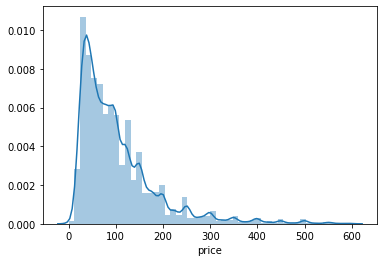

time: 641 ms


In [18]:
sns.distplot(data_train[data_train.price < data_train.price.quantile(0.99)].price)

In [19]:
data_train['require_guest_phone_verification'].value_counts()

f    51173
t      642
Name: require_guest_phone_verification, dtype: int64

time: 16 ms


In [20]:
category_columns = ['host_is_superhost', 'host_identity_verified', 'neighbourhood_cleansed', 'is_location_exact', 'property_type', 'cancellation_policy', 'require_guest_profile_picture']
time_cols = ['host_since']
text_columns = ['space', 'name','summary', 'description','neighborhood_overview', 'transit', 'access', 'interaction', 'house_rules', 'host_about', 'amenities']
to_drop = ['square_feet', 'host_response_time', 'notes', 'space', 'experiences_offered', 'host_has_profile_pic', 'zipcode', 'require_guest_profile_picture'] #

time: 0 ns


In [21]:
data_train[to_drop].isna().sum()

square_feet                      51800
host_response_time               20686
notes                            32379
space                            18465
experiences_offered                  0
host_has_profile_pic                11
zipcode                           1473
require_guest_profile_picture        0
dtype: int64

time: 47 ms


In [22]:
data_train['zipcode'].value_counts()

E1         337
E2         245
NW1        231
N1         227
SE1        206
          ... 
TW1 4HG      1
SW7 1AA      1
NW5 2PN      1
N7 9RW       1
E10 7LZ      1
Name: zipcode, Length: 23654, dtype: int64

time: 31 ms


In [23]:
data_train.host_id.shape, data_test.host_id.shape,

((51815,), (23000,))

time: 0 ns


In [24]:
len(set(data_train.host_id.unique()) & set(data_test.host_id.unique()))

2118

time: 31 ms


In [25]:
set(data_train.host_id.unique()) & set(data_test.host_id.unique())

{14188548,
 2998283,
 2572307,
 9527315,
 52838429,
 19791905,
 860194,
 31752227,
 66715692,
 15990831,
 5537842,
 15417396,
 32817207,
 10190908,
 18825280,
 7495745,
 69083203,
 4456517,
 9846855,
 5046349,
 2490448,
 7938129,
 9240658,
 16138323,
 67371094,
 1998937,
 6987866,
 11616348,
 737373,
 28467292,
 24363103,
 44441704,
 42492023,
 30253178,
 13770877,
 9044100,
 6996100,
 12058758,
 9609350,
 38142089,
 64733326,
 44679311,
 2138262,
 41132182,
 10961046,
 31408288,
 4579491,
 12075172,
 909476,
 41025705,
 9871531,
 27697324,
 62980270,
 9388211,
 8356021,
 14852284,
 245950,
 57991359,
 2719939,
 5595334,
 1622216,
 67879112,
 17539274,
 1482955,
 9396431,
 4325599,
 377059,
 30343396,
 9527523,
 4792552,
 4137192,
 1532140,
 45367540,
 12189949,
 48226558,
 20300039,
 23101705,
 418061,
 21201170,
 23986451,
 46375189,
 4309270,
 1958174,
 17572127,
 17662250,
 2490666,
 6111530,
 56484140,
 5964084,
 31269173,
 52928821,
 24289591,
 33448255,
 5660994,
 44114247,
 559

time: 62 ms


In [26]:
data_train.host_id.value_counts()

33889201     792
147514538    179
1432477      153
28820321     152
136223256    120
            ... 
23949978       1
23558811       1
76434077       1
97473182       1
136360941      1
Name: host_id, Length: 32606, dtype: int64

time: 16 ms


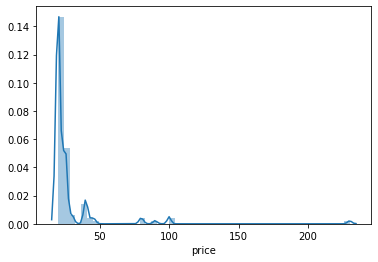

time: 500 ms


In [27]:
sns.distplot(data_train[data_train['host_id'] == 136223256].price)

In [28]:
data_train[category_columns].nunique()

host_is_superhost                 2
host_identity_verified            2
neighbourhood_cleansed           33
is_location_exact                 2
property_type                    40
cancellation_policy               6
require_guest_profile_picture     2
dtype: int64

time: 47 ms


### Удалим выборсы по цене 

In [29]:
data_train = data_train[(data_train.price < data_train.price.quantile(0.98)) & (data_train.price > data_train.price.quantile(0.005))]

time: 63 ms


### Добавим календарь

In [30]:
calendar = pd.read_csv('calendar.csv')

time: 16 s


In [31]:
calendar.head()

,listing_id,date,available
0,9554,2019-08-18,t
1,97446,2019-11-04,f
2,97446,2019-11-03,f
3,97446,2019-11-02,f
4,97446,2019-11-01,f


time: 16 ms


In [32]:
days_available = pd.crosstab(calendar['listing_id'], calendar['available'])

time: 11.4 s


In [33]:
def get_availble_days(x, days_available=days_available):
    try:
        return days_available.loc[x, 't']
    except KeyError:
        return 0

time: 0 ns


In [34]:
data_train['days_available'] = data_train['id'].apply(lambda x: get_availble_days(x))
data_test['days_available'] = data_test['id'].apply(lambda x: get_availble_days(x))

time: 1.8 s


### Посмотрим отзывы

In [35]:
reviews['reviewer_name'].value_counts()

David              9784
Michael            7127
Sarah              6730
John               6027
Laura              5795
                   ... 
Wan Anuar             1
Emma / Alastair       1
Tsekeri               1
Abiba                 1
Elizabeth Jill        1
Name: reviewer_name, Length: 114161, dtype: int64

time: 594 ms


In [51]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,9554,1184025,2012-04-26,1809049,Hana,"I stayed in London for a month to study, exp..."
1,9554,1206322,2012-04-30,2237488,Rishi,My bnb request was very last minute and i was ...
2,9554,1258541,2012-05-10,2150467,Panee,First time as airbnb!First time to London! I c...
3,9554,1405284,2012-06-03,1864672,Simone Cristina,A wonderful experience! The house is very well...
4,9554,1475969,2012-06-13,2438453,Sondra,We are so grateful that we trusted our intuiti...


time: 15 ms


In [52]:
count_rewiews = reviews['listing_id'].value_counts()

time: 63 ms


In [53]:
def get_review_number(x, count_rewiews=count_rewiews):
    try:
        return count_rewiews[x]
    except KeyError:
        return 0

time: 0 ns


In [54]:
data_train['rewiews_cnt'] = data_train['id'].apply(lambda x: get_review_number(x))
data_test['rewiews_cnt'] = data_test['id'].apply(lambda x: get_review_number(x))

time: 1.74 s


In [55]:
reviews['comments'].iloc[-888]

'I had to find a place really quick and Elaine answer immediatly and made everything to make me feel confortable !\nThe place is neat and well equiped, very close to the center and well known place of London.'

time: 0 ns


In [56]:
def get_review_cat(x, data_train):
    return data_train[data_train['id'] == x].loc[:, 'price_cat'].mean()

time: 0 ns


In [57]:
from sklearn.cluster import KMeans

time: 94 ms


In [58]:
review_train = pd.merge(reviews.set_index('listing_id'), data_train.set_index('id'), left_index=True, right_index=True, how='inner')

time: 3.09 s


In [59]:
review_test = pd.merge(reviews.set_index('listing_id'), data_test.set_index('id'), left_index=True, right_index=True, how='inner')

time: 2.78 s


In [60]:
def findall_words(x):
    try:
        return ' '.join(re.findall(r'\w+', x))
    except TypeError:
        return None

time: 0 ns


In [61]:
review_train['comments'] = review_train['comments'].apply(lambda x: findall_words(x))

time: 11.9 s


In [62]:
vectorizer = TfidfVectorizer(stop_words='english', min_df=5, max_df=0.5)
clf = LogisticRegression(penalty='l2', random_state=17)

time: 0 ns


In [63]:
def pipe_text (vectorizer, classifier):
    return(Pipeline([("vectorizer", vectorizer),
                            ("classifier", classifier)]))

time: 0 ns


In [64]:
pipe_rew = pipe_text(vectorizer, clf)

time: 0 ns


In [65]:
pipe_rew.fit(review_train[review_train.comments.notna()]['comments'], review_train[review_train.comments.notna()].price_cat)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.5, min_df=5, stop_words='english')),
                ('classifier', LogisticRegression(random_state=17))])

time: 1min 16s


In [66]:
rew_train_ans = pipe_rew.predict(review_train[review_train.comments.notna()].comments)

time: 25.3 s


In [67]:
rew_train_ans = pd.DataFrame(list(zip(rew_train_ans, review_train[review_train.comments.notna()].index)), columns=['cat', 'id'])

time: 1.06 s


In [68]:
rew_test_ans = pipe_rew.predict(review_test[review_test.comments.notna()].comments)

time: 39.8 s


In [69]:
rew_test_ans = pd.DataFrame(list(zip(rew_test_ans, review_test[review_test.comments.notna()].index)), columns=['cat', 'id'])

time: 1.3 s


In [70]:
def get_cat(x, rew):
    try:
        return rew[rew['id'] == x]['cat'].mean()
    except:
        return -5

time: 0 ns


In [71]:
data_train['rew_cat'] = data_train['id'].apply(lambda x: get_cat(x, rew_train_ans))

time: 1min 12s


In [72]:
data_test['rew_cat'] = data_test['id'].apply(lambda x: get_cat(x, rew_test_ans))

time: 39.9 s


### Generate categories from text features

In [36]:
stop_words = stopwords.words('english')
def drop_stop_words(tokenized_sentence: list, stop_words: list):
    return [t for t in tokenized_sentence if t not in stop_words]

def stem(tokenized_sentence: list, stemmer):
    return ' '.join([stemmer.stem(word) for word in tokenized_sentence])
def lem(tokenized_sentence: list, wordnet_lemmatizer):
    try:
        lemmatize_words = np.vectorize(wordnet_lemmatizer.lemmatize)
        lemmatized_text = ' '.join(lemmatize_words(tokenized_sentence))
        return lemmatized_text
    except ValueError:
        print(tokenized_sentence)
        return ' '.join(tokenized_sentence)

time: 16 ms


In [37]:
wordnet_lemmatizer = WordNetLemmatizer()
sp = spacy.load('en_core_web_sm')
stemmer = SnowballStemmer(language='english')

time: 4.17 s


In [38]:
def normalise_cust(x):
    try:
        normalise(word_tokenize(x), verbose=False)
    except IndexError:
        print(x)
        return x

time: 0 ns


In [39]:
for col in text_columns:
    print(col)
    data_train[col] = data_train[col].fillna('Unknown words')
    data_train[col] = data_train[col].apply(lambda x: ' '.join(re.findall(r'\w+', x)))
    data_train[col] = data_train[col].apply(lambda x: x.strip())
    #data_train[col] = data_train[col].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    #data_train[col] = data_train[col].apply(lambda x: normalise_cust(x))
    #data_train[col] = data_train[col].apply(lambda x: drop_stop_words(x, stop_words))
    #data_train[col] = data_train[col].apply(lambda x: stem(x, stemmer))
    #data_train[col] = data_train[col].apply(lambda x: lem(x, wordnet_lemmatizer))


space
name
summary
description
neighborhood_overview
transit
access
interaction
house_rules
host_about
amenities
time: 21.3 s


In [40]:
for col in text_columns:
    print(col)
    data_test[col] = data_test[col].fillna('Unknown words')
    data_test[col] = data_test[col].apply(lambda x: ' '.join(re.findall(r'\w+', x)))
    data_test[col] = data_test[col].apply(lambda x: x.strip())
    #data_test[col] = data_test[col].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    #data_train[col] = data_train[col].apply(lambda x: normalise_cust(x))
    #data_test[col] = data_test[col].apply(lambda x: drop_stop_words(x, stop_words))
    #data_test[col] = data_test[col].apply(lambda x: stem(x, stemmer))
    #data_test[col] = data_test[col].apply(lambda x: lem(x, wordnet_lemmatizer))


space
name
summary
description
neighborhood_overview
transit
access
interaction
house_rules
host_about
amenities
time: 8.67 s


In [41]:
text_columns

['space',
 'name',
 'summary',
 'description',
 'neighborhood_overview',
 'transit',
 'access',
 'interaction',
 'house_rules',
 'host_about',
 'amenities']

time: 0 ns


In [42]:
boarders = np.geomspace(data_train.price.min(), data_train.price.max(), num=5)

time: 16 ms


In [43]:
def get_cat_price(x, boarders):
    for i, b in enumerate(boarders[1:]):
        if x <= b:
            return i
    return i + 1

time: 0 ns


In [44]:
data_train['price_cat'] = data_train['price'].apply(lambda x: get_cat_price(x, boarders))

time: 125 ms


In [45]:
data_train[text_columns].isna().sum()

space                    0
name                     0
summary                  0
description              0
neighborhood_overview    0
transit                  0
access                   0
interaction              0
house_rules              0
host_about               0
amenities                0
dtype: int64

time: 94 ms


In [46]:
def pipe_text (vectorizer, classifier):
    return(Pipeline([("vectorizer", vectorizer),
                            ("classifier", classifier)]))

time: 0 ns


In [47]:
vectorizer = TfidfVectorizer(stop_words='english', min_df=5, max_df=0.5)
clf = LogisticRegression(penalty='l2', random_state=17)

time: 0 ns


In [48]:
pipe_txt = pipe_text(vectorizer, clf)

time: 0 ns


In [49]:
for col in text_columns:
    data_train[col] = data_train[col].apply(lambda x: 'unknown' if x == '' else x)
    pipe_txt = pipe_text(vectorizer, clf)
    pipe_txt.fit(data_train[col], data_train['price_cat'])
    data_train[f'{col}_cat'] = pipe_txt.predict(data_train[col].fillna('Unknown'))
    data_test[f'{col}_cat'] = pipe_txt.predict(data_test[col].fillna('Unknown'))

time: 2min 10s


In [50]:
cat_cols2 = [f'{col}_cat' for col in text_columns]

time: 0 ns


### Boruta feature selection

In [ ]:
def pipeline_model_bor (category_columns1, numeric_columns, feature_selection_alg):
    numeric_steps = [('selection', FunctionTransformer(lambda x: x[numeric_columns], validate=False)), 
                    ('imputing', SimpleImputer(missing_values=np.nan, strategy='mean', fill_value=None)),
                    ('scaling', StandardScaler())]
    category_steps1 = [('selection', FunctionTransformer(lambda x: x[category_columns1], validate=False)),
                       ('imputing', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='unknown')),
                       ('hot_encoding', OneHotEncoder(handle_unknown = 'ignore', sparse=False))]
    return (Pipeline(steps =[('feature_processing', FeatureUnion(transformer_list = [
            ('numeric_variables_processing', Pipeline(steps = numeric_steps)),
            ('category1_variables_processing', Pipeline(steps = category_steps1))])),
            ('feature selection', BorutaPy(feature_selection_alg, n_estimators='auto', verbose=2, random_state=4242, max_iter = 50, perc = 70))]))
                    


In [ ]:
pipe_bor = pipeline_model_bor(category_columns + cat_cols2, num_cols, RandomForestRegressor(n_jobs=-1, max_depth=5))#CatBoostRegressor(verbose=False)

In [ ]:
pipe_bor.fit(data_train, data_train.price)

In [ ]:
cat1_feature_names = pipe_bor.get_params()['steps'][0][1].get_params(
                )['transformer_list'][1][1].get_params()['steps'][2][1].get_feature_names()

In [ ]:
features_df = pd.DataFrame(pipe_bor['feature selection'].ranking_, index=num_cols + cat1_feature_names.tolist(), columns=['rank'])

In [ ]:
features_df['keep'] = pipe_bor['feature selection'].support_
features_df

In [ ]:
selected_features = np.where(pipe_bor['feature selection'].support_ == True)

In [ ]:
selected_features[0]

### Host_since to num

In [73]:
data_train['host_since'] = pd.to_datetime(data_train['host_since'])

time: 78 ms


In [74]:
(data_train['host_since'].max() - data_train['host_since'].min()).total_seconds() / (3600 * 24) , (data_train['host_since'].max() - data_train['host_since'].min())

(3623.0, Timedelta('3623 days 00:00:00'))

time: 16 ms


In [75]:
min_date = data_train['host_since'].min()

time: 16 ms


In [76]:
data_train['since'] = data_train['host_since'].apply(lambda x: (x - min_date).total_seconds() / (3600 * 24))

time: 1.55 s


In [77]:
data_train.price.median()

80.0

time: 0 ns


In [78]:
data_test['host_since'] = pd.to_datetime(data_test['host_since'])

time: 31 ms


In [79]:
data_test['since'] = data_test['host_since'].apply(lambda x: (x - min_date).total_seconds() / (3600 * 24))

time: 625 ms


### Финальная модель

In [80]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.abs(np.array(y_true)-np.array(y_pred)).mean()

time: 0 ns


In [81]:
from sklearn.metrics import make_scorer
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

time: 0 ns


In [82]:
def select_cols(X):
    print(X.shape, X[:, selected_features[0]].shape)
    return X[:, selected_features[0]]

time: 0 ns


In [83]:
def pipeline_model(category_columns1, numeric_columns, regressor):
    numeric_steps = [('selection', FunctionTransformer(lambda x: x[numeric_columns], validate=False)), 
                    ('imputing', SimpleImputer(missing_values=np.nan, strategy='most_frequent', fill_value=None))] #mean
                    #('scaling', StandardScaler())]
    category_steps1 = [('selection', FunctionTransformer(lambda x: x[category_columns1], validate=False)),
                       ('imputing', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='unknown')),
                       ('hot_encoding', OneHotEncoder(handle_unknown = 'ignore', sparse=False))]
    return (Pipeline(steps =[('feature_processing', FeatureUnion(transformer_list = [
            ('numeric_variables_processing', Pipeline(steps = numeric_steps)),
            ('category1_variables_processing', Pipeline(steps = category_steps1))])),
            #('selection', FunctionTransformer(select_cols, validate=False)),
            ('model_fitting', regressor)]))
                    

time: 0 ns


In [84]:
from sklearn.pipeline import make_pipeline
def pipeline_model(category_columns1, numeric_columns, regressor):
    numeric_steps = [('selection', FunctionTransformer(lambda x: x[numeric_columns], validate=False)), 
                    ('imputing', SimpleImputer(missing_values=np.nan, strategy='most_frequent', fill_value=None))] #mean
                    #('scaling', StandardScaler())]
    category_steps1 = [('selection', FunctionTransformer(lambda x: x[category_columns1], validate=False)),
                       ('imputing', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='unknown')),
                       ('hot_encoding', OneHotEncoder(handle_unknown = 'ignore', sparse=False))]
    return make_pipeline(Pipeline(steps =[('feature_processing', FeatureUnion(transformer_list = [
            ('numeric_variables_processing', Pipeline(steps = numeric_steps)),
            ('category1_variables_processing', Pipeline(steps = category_steps1))])),
            #('selection', FunctionTransformer(select_cols, validate=False)),
            ('model_fitting', regressor)]))
                    

time: 0 ns


In [85]:
num_cols = ['accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'square_feet',
 'security_deposit',
 'cleaning_fee',
 'guests_included',
 'extra_people',
 'minimum_nights',
 'latitude',
 'longitude']

time: 16 ms


In [86]:
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor

time: 0 ns


In [102]:
pipe = pipeline_model(category_columns + cat_cols2, num_cols + ['rewiews_cnt', 'days_available', 'since', 'rew_cat'],
                      LGBMRegressor(n_estimators=700, num_leaves=1000, objective='mape', random_state=17)) #  

time: 0 ns


In [123]:
pipe2 = pipeline_model(category_columns + cat_cols2, num_cols + ['rewiews_cnt', 'days_available', 'since', 'rew_cat'],
                      CatBoostRegressor(objective='MAPE', verbose=False))

time: 0 ns


In [89]:
pipe3 = pipeline_model(category_columns + cat_cols2, num_cols + ['rewiews_cnt', 'days_available', 'since', 'rew_cat'],
                      Ridge())

time: 0 ns


In [125]:
pipe4 = pipeline_model(category_columns + cat_cols2, num_cols + ['rewiews_cnt', 'days_available', 'since', 'rew_cat'],
                      KNeighborsRegressor())

time: 0 ns


In [126]:
cross_val_score(pipe4, data_train, data_train['price'], scoring=mape_scorer)

array([-39.31026631, -39.45142574, -41.06065347, -44.79150495,
       -48.8849901 ])

time: 22.6 s


In [155]:
from sklearn.ensemble import StackingRegressor
estimators = [
     ('lr1', pipe),
     ('lr2', pipe2),
     ('lr3', pipe3),
     ('lr4', pipe4),
 ]

time: 0 ns


In [174]:
reg = StackingRegressor(
     estimators=estimators,
     final_estimator=LGBMRegressor(
         n_estimators=100, num_leaves=300, objective='mape', random_state=42))

time: 0 ns


In [175]:
reg.fit(data_train, data_train['price'])

StackingRegressor(estimators=[('lr1',
                               Pipeline(steps=[('pipeline',
                                                Pipeline(steps=[('feature_processing',
                                                                 FeatureUnion(transformer_list=[('numeric_variables_processing',
                                                                                                 Pipeline(steps=[('selection',
                                                                                                                  FunctionTransformer(func=<function pipeline_model.<locals>.<lambda> at 0x000002011C9E92F0>)),
                                                                                                                 ('imputing',
                                                                                                                  SimpleImputer(strategy='most_frequent'))])),
                                                                  

time: 16min 26s


In [171]:
cross_val_score(reg, data_train, data_train['price'], scoring=mape_scorer, cv=3)

array([-22.87186498, -23.12800208, -25.82257524])

time: 28min 37s


In [112]:
np.array([-21.1036623 , -22.0597957 , -22.44692457, -25.47907606,
       -24.66699728]).mean()

-23.151291182

time: 15 ms


In [173]:
np.array([-22.87186498, -23.12800208, -25.82257524]).mean()

-23.9408141

time: 0 ns


In [143]:
pipe_params={
          #'model_fitting__objective':['mae', 'mape', 'mse'],
    #'model_fitting__num_leaves':[200, 300, 400, 500, 600], 
    #'model_fitting__n_estimators':[50, 100, 150, 200, 300] learning_rate
    #'model_fitting__learning_rate':[0.1, 0.07, 0.05, 0.01]
}

time: 0 ns


In [ ]:
grid = GridSearchCV(pipe, param_grid=pipe_params, scoring=mape_scorer)

In [ ]:
grid.fit(data_train, data_train['price'])

In [ ]:
cv_result = pd.DataFrame.from_dict(grid.cv_results_)

In [ ]:
cv_result.sort_values('rank_test_score')

In [103]:
pipe.fit(data_train, data_train['price'])

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('feature_processing',
                                  FeatureUnion(transformer_list=[('numeric_variables_processing',
                                                                  Pipeline(steps=[('selection',
                                                                                   FunctionTransformer(func=<function pipeline_model.<locals>.<lambda> at 0x000002011C9E92F0>)),
                                                                                  ('imputing',
                                                                                   SimpleImputer(strategy='most_frequent'))])),
                                                                 ('category1_variables_processing',
                                                                  Pipeline(ste...('selection',
                                                                                   FunctionTransformer(func=<function pipeline

time: 1min 32s


In [176]:
result = reg.predict(data_test)

time: 12.1 s


In [177]:
np.round(result)

array([ 36.,  58.,  53., ..., 133.,  98.,  39.])

time: 15 ms


In [178]:
data_test['price'] = np.round(result)

time: 0 ns


In [179]:
data_test[['id', 'price']].to_csv('submission.csv', index=False)

time: 171 ms


In [ ]:
fig, axes = plt.subplots(len(num_cols), figsize=(16, 50), sharey=False)
for i, col in enumerate(num_cols):
    sns.distplot(data_train[col], ax=axes[i], color='b')
    sns.distplot(data_test[col], ax=axes[i], color='r')
    axes[i].set_title(col)

In [ ]:
cat1_feature_names = pipe.get_params()['steps'][0][1].get_params(
                )['transformer_list'][1][1].get_params()['steps'][2][1].get_feature_names()

In [ ]:
features_df = pd.DataFrame(pipe['model_fitting'].feature_importances_, index=num_cols + cat1_feature_names.tolist(), columns=['selected'])

In [ ]:
pd.options.display.max_rows = 150
features_df.sort_values(by='selected', ascending=False)

### Идеи
в lgbm mape заменить заменить на стандартное <br>
попробовать другие ограничения сверху-снизу для входной цены <br>
Изменить количество категорий для текстовых фичей <br>
Округлить ответ до целых